In [18]:
%matplotlib inline
import datetime as datetime
from sklearn import datasets, linear_model
from sklearn import preprocessing as pre
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import requests
import seaborn as sb
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib

In [44]:
conso = pd.read_csv('conso_train.csv', sep=';')
conso.date = pd.to_datetime(conso.date)
#On ajoute une seconde à la date car elle est sous la forme 22:59:59 jusqu'à fin décembre
conso.date = conso.date + datetime.timedelta(0,1); 
conso.index = conso.date
#Puis elle est sous la forme 22:00:00 à partir de début 2016 donc on re-rajoute une seconde à partir de là
conso2 = conso[2642:]
conso2.date = conso2.date - datetime.timedelta(0,1);
#et on fusionne le tout (using .loc[row_indexer,col_indexer] = value instead)
conso[2642:] = conso2;
conso = conso.drop(['date'], axis=1)

meteo = pd.read_csv('meteo_train.csv', sep=';', usecols=['Date UTC', 'T¬∞ (C)', 'P (hPa)', 'HR (%)', 'P.ros√©e (¬∞C)', 'Visi (km)', 'Vt. moy. (km/h)','Vt. raf. (km/h)', 'Vt. dir (¬∞)','RR 3h (mm)','Neige (cm)','Nebul. (octats)'])
meteo.columns = ['date','temp','pression','hr','pros','visi','vmoy','vraf','vdir','rr','neige','nebul']
#Pour éviter les glitchs sur la date de météo
meteo.date = meteo.date.str.replace('h', ':')
meteo.date = pd.to_datetime(meteo.date, format='%d/%m/%y %H:%M')
meteo.date = meteo.date.dt.strftime('%Y-%m-%d %H:%M:%S')
meteo.index = meteo.date
meteo = meteo.drop(['date'], axis=1);

#Finalement on merge les deux tables pour en obtenir une seule contenant tous les données dont nous avons besoin
df = pd.merge(conso, meteo, right_index = True, left_index = True)
df = df.drop(['rr'], axis=1)
df = df.drop(['neige'], axis=1)
df = df.drop(['nebul'], axis=1)

df = df.dropna(axis = 0, how ='any')

#On divise la dataframe en deux dataframe, une d'entrainement et une de test
train_conso = df[0:2803]
test_conso = df[2804:2860]

#On crée une liste contenant les noms des colonnes de notre dataframe
names_meteo = ['temp','pression','hr','pros','visi','vmoy','vraf','vdir']
names_conso = ['weekday','week','jour']+mois+heures

D:\Programmes\Anaconda\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



Régréssion linéaire : temp


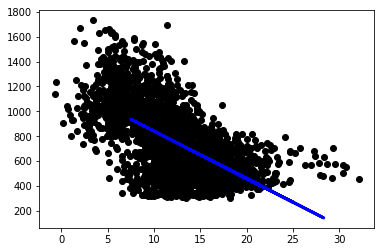

Coefficients: 
 [[-38.13790516]]
Mean squared error: 36235.36
Variance score: -2.33
Score : -17527.07261714803

Régréssion linéaire : pression


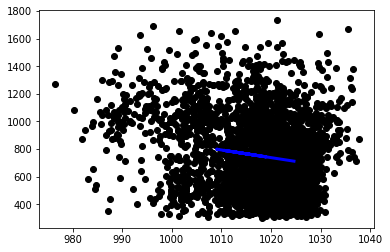

Coefficients: 
 [[-5.53980779]]
Mean squared error: 85384.55
Variance score: -6.85
Score : -18470.983463682707

Régréssion linéaire : hr


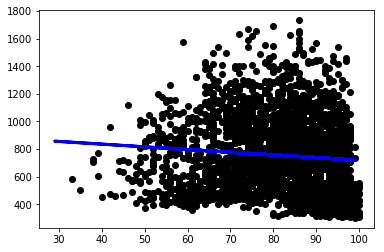

Coefficients: 
 [[-1.94924164]]
Mean squared error: 80035.95
Variance score: -6.36
Score : -804.3037690272927

Régréssion linéaire : pros


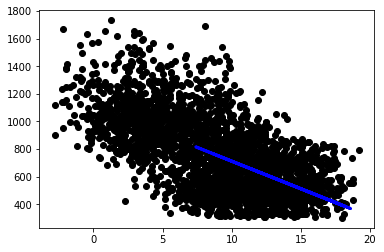

Coefficients: 
 [[-39.87114494]]
Mean squared error: 23597.16
Variance score: -1.17
Score : -31413.56891638554

Régréssion linéaire : visi


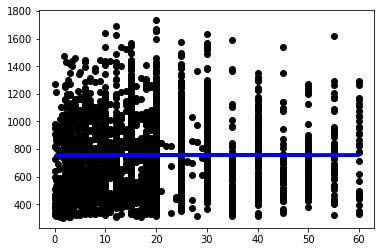

Coefficients: 
 [[0.03648576]]
Mean squared error: 82060.33
Variance score: -6.54
Score : -700.0255029906602

Régréssion linéaire : vmoy


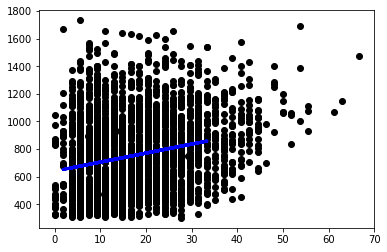

Coefficients: 
 [[6.5161031]]
Mean squared error: 82216.96
Variance score: -6.56
Score : -3133.4501508774333

Régréssion linéaire : vraf


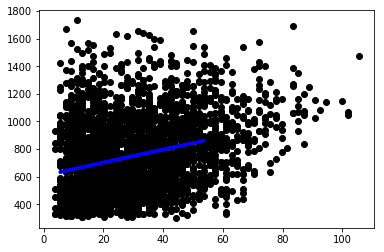

Coefficients: 
 [[4.71314496]]
Mean squared error: 80213.81
Variance score: -6.37
Score : -1328.8709344054585

Régréssion linéaire : vdir


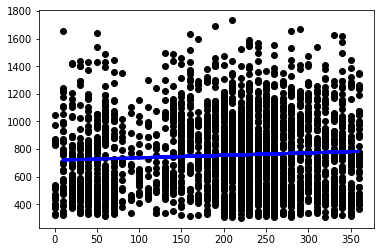

Coefficients: 
 [[0.17831]]
Mean squared error: 80977.21
Variance score: -6.44
Score : -17.87804718289864


In [46]:
for i in range(len(names_temp)):
        print('\nRégréssion linéaire : ' + names_temp[i])

        train_conso = train_conso[0:len(train_conso[names_temp[i]])]
        reg = linear_model.LinearRegression()
        reg.fit([[x] for x in train_conso[names_temp[i]]],[[x] for x in train_conso.puissance])
        
        conso_y_pred = reg.predict([[x] for x in test_conso[names_temp[i]]])
        score_pred = reg.score([[x] for x in test_conso.puissance], conso_y_pred)
        
        plt.scatter([[x] for x in train_conso[names_temp[i]]],[[x] for x in train_conso.puissance], color='black')
        plt.plot([[x] for x in test_conso[names_temp[i]]], conso_y_pred,color='blue', linewidth=3)

        plt.show()
        print('Coefficients: \n', reg.coef_)
        # The mean squared error

        print("Mean squared error: %.2f"
              % mean_squared_error(test_conso.puissance, conso_y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % r2_score(test_conso.puissance, conso_y_pred))
        print('Score :' ,score_pred)

Coefficients: 
 [[-19.68632554  -2.31411888 -23.41968521   6.86279453]]
Mean squared error: 24013.41
Variance score: -1.21
Score : -17.87804718289864


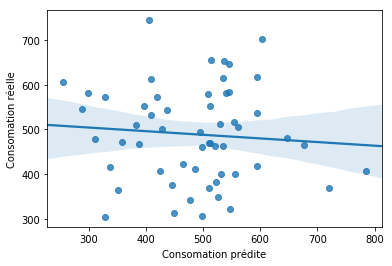

In [54]:
names_meteo1 = ['temp','pression','pros','vmoy']
elts_train=[]
elts_test=[]
#On va créer une liste des valeurs d'entrainement
for i in range(len(train_conso)):
    conso_interm = []
    for j in range(len(names_meteo1)):
        conso_interm.append(train_conso[names_meteo1[j]][i])
    elts_train.append(conso_interm)
    
#On va créer une liste des valeurs de test    
for i in range(len(test_conso)):
    conso_interm = []
    for j in range(len(names_meteo1)):
        conso_interm.append(test_conso[names_meteo1[j]][i])
    elts_test.append(conso_interm)
    
#On choisit la méthode de regression que l'on souhaite utilisé   
reg_linear = linear_model.LinearRegression()

#On fit les données d'entrainement 
reg_linear.fit(elts_train, [[x] for x in train_conso.puissance])

#On prédit des valeurs de puissance grâce aux valeurs de test 
conso_y_pred_linear = reg_linear.predict(elts_test)

#On réalise un scatter plot des données prédites
sb.regplot(conso_y_pred_linear, test_conso.puissance, scatter = True)
plt.xlabel("Consomation prédite")
plt.ylabel("Consomation réelle")

print('Coefficients: \n', reg.coef_)
# The mean squared error

print("Mean squared error: %.2f"
    % mean_squared_error(test_conso.puissance, conso_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(test_conso.puissance, conso_y_pred))
print('Score :' ,score_pred)